# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,Lasso,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing,cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sb
import matplotlib.pyplot as plt
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1) Data Exploration

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

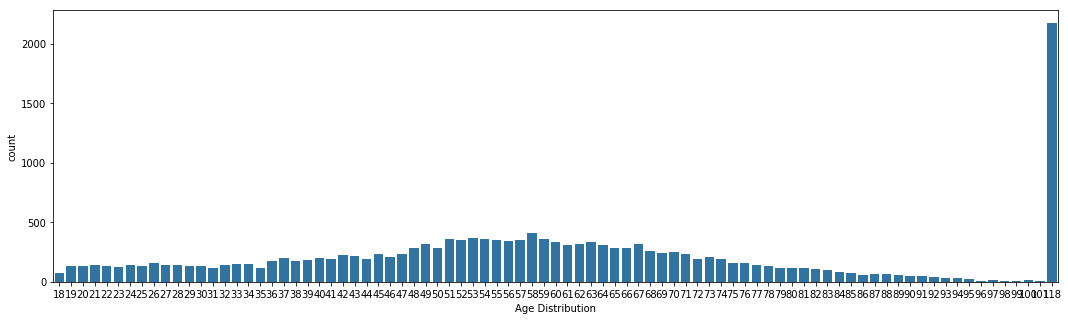

In [6]:
plt.figure(figsize=[18, 5])
ax = sb.countplot(data = profile, x ='age',color = sb.color_palette()[0])
plt.xlabel('Age Distribution');
#plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120]);
#plt.show()

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [9]:
portfolio.shape

(10, 6)

## 2) Data Wrangling

In [10]:
def clean_portfolio(portfolio):
    '''
    INPUT:
    portfolio - original dataframe read from portfolio json file
    
    OUTPUT:
    df        - cleaned and extended portfolio dataframe 
    
    Description:
    this function gets the portfolio dataframe and add extra fields to it based on the channel
    and offer_type columns, for each type a new columns would be created and re-order the columns
    
    '''
    
    df = portfolio.copy()
    #df['web'] = df['channels'].apply(lambda x:1 if 'web' in df['channels'] else 0)
    #df['email'] = df['channels'].apply(lambda x:1 if 'email' in df['channels'] else 0)
    #df['mobile'] = df['channels'].apply(lambda x:1 if 'mobile' in df['channels'] else 0)
    #df['social'] = df['channels'].apply(lambda x:1 if 'social' in df['channels'] else 0)
    dropped_cols = ['channels','offer_type']
    channels = set()
    #loop through the rows
    for index,row in df.iterrows():
        #get the channels from the row
        row_channels = str(row[0]).strip()
        #remove the [ and ] from the row_channels
        row_channels = row_channels[1:-1]
        #remove the ' from row_channels
        row_channels = row_channels.replace("'",'').strip()
        #split the channels per channel and save in split_columns
        split_columns = row_channels.split(",")
        #loop through channels in the split_columns 
        for channel in split_columns:
            channel = channel.strip()
            #since the channel is availabe in the row, make the corresponding columsn for it as 1
            df.loc[index,channel] = 1
            #update the channel to the channels list to fillna later
            channels.update([channel])
    
    for channel in channels:
        df[channel].fillna(0,inplace=True)
        
    cols = df.columns.tolist()
    #re-order the dataframe columns by bringing id in the begining
    cols = cols[-7:-6] + cols[:-7] + cols[-6:]
    df = df[cols]
    #use get dummies to create the new columns and entries for offer_type column and concatenate it with df
    df = pd.concat([df, pd.get_dummies(df['offer_type'])], axis=1)
    #drop the not needed columns
    df = df.drop(dropped_cols,axis=1)
    return df

In [11]:
portfolio_clean = clean_portfolio(portfolio)
portfolio_clean

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1.0,1.0,1.0,0.0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1.0,1.0,1.0,1.0,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1.0,1.0,0.0,1.0,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1.0,1.0,0.0,1.0,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1.0,0.0,0.0,1.0,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1.0,1.0,1.0,1.0,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1.0,1.0,1.0,1.0,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1.0,1.0,1.0,0.0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1.0,1.0,1.0,1.0,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1.0,1.0,0.0,1.0,0,1,0


In [12]:
def clean_profile(profile):
    '''
    INPUT:
    profile - original dataframe read from profile json file
    
    OUTPUT:
    df        - cleaned and extended profile dataframe 
    
    Description:
    this function gets the profile dataframe and make the defauls age '118' as nan and add extra 
    fields to it, 10 columns will be added to capture the decade for the age and create 3 more columns
    for gender and re-rder the profile df
    '''
    
    dropped_cols = ['gender']
    df = profile.copy()
    cols = df.columns.tolist()
    #re-order the df by bringin id in the beginning
    cols = cols[-2:-1]+cols[:-2]+cols[-1:]
    df = df[cols]
    #make the default age 118 as nan
    df['age'] = df['age'].apply(lambda x:np.nan if (x == 118) else x)
    for i in range(11):
        if i != 0:
            #calculate the decade the person lives in ...
            stage = i * 10
            df[str(stage)+"'s"] = df['age'].apply(lambda x:1 if((x-stage<10)and (x-stage>=0)) else 0)
#    df['gender'] = df.gender.map({'None':0, 'M':1, 'F':2, 'O':3})
    df = pd.concat([df, pd.get_dummies(df['gender'],prefix='gender')], axis=1)
    df = df.drop(dropped_cols,axis=1)
    return df

In [13]:
profile_clean = clean_profile(profile)
profile_clean.head()

,id,age,became_member_on,income,10's,20's,30's,40's,50's,60's,70's,80's,90's,100's,gender_F,gender_M,gender_O
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,20170212,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,55.0,20170715,112000.0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,20180712,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,20170509,100000.0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,NaN,20170804,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
def clean_transcript(transcript):
    '''
    INPUT:
    transcript - original dataframe read from transcript json file
    
    OUTPUT:
    df        - cleaned and extended transcript dataframe 
    
    Description:
    this function gets the transcript dataframe and rename the person field to id and create offer_id, reward and transaction_amount 
    columns also it create 4 new columns based on the event column.
    a re-order df is returned making id the first column
    '''
    dropped_cols = ['comp_offer_id','value','event']
    df = transcript.copy()
    df = df.rename(columns = {'person':'id'})
    cols = df.columns.tolist()
    #re-order the df by brining id to be the first column
    cols = cols[-3:-2] + cols[:-3] + cols[-2:]
    df = df[cols]
    # create new column offer_id whic is based on the value column
    df['offer_id'] = df['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else '')
    df['comp_offer_id'] = df['value'].apply(lambda x: x['offer_id'] if ('offer_id' in x) else '')
    df['offer_id'] = df['offer_id']+df['comp_offer_id']
    df['reward'] = df['value'].apply(lambda x: x['reward'] if ('reward' in x) else np.nan)
    df['transaction_amount'] = df['value'].apply(lambda x: x['amount'] if ('amount' in x) else np.nan)
    df['offer_id'] = df['offer_id'].apply(lambda x:x if (x!='') else np.nan)
    df = pd.concat([df, pd.get_dummies(df['event'])], axis=1)
    df = df.drop(dropped_cols,axis=1)
    return df

In [15]:
transcript_clean = clean_transcript(transcript)
transcript_clean.head()

,id,time,offer_id,reward,transaction_amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


In [16]:
transcript_clean.transaction_amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: transaction_amount, dtype: float64

In [17]:
transcript_clean.transaction.sum()

138953

In [18]:
def offer_mapping_keyval(key_val):
    '''
    INPUT:
    key_val - a string wither it is a key or value to map the offer name to and ID and vice versa
    
    OUTPUT:
    val        - if the key_val is a key, the value mapping is returned (offer name)
    key        - if the key_val is a value, the key mapping is returned (offer id)
    0          - if nothing found, not key or val then return 0
    
    Description:
    this function gets maps the offer ID to the offer name , or vice versa
    '''
    offer_mapping = {'0b1e1539f2cc45b7b9fa7c272da2e1d7':'offer_1',
       '2298d6c36e964ae4a3e7e9706d1fb8c2':'offer_2',
       '2906b810c7d4411798c6938adc9daaa5':'offer_3',
       '3f207df678b143eea3cee63160fa8bed':'offer_4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0':'offer_5',
       '5a8bc65990b245e5a138643cd4eb9837':'offer_6',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9':'offer_7',
       'ae264e3637204a6fb9bb56bc8210ddfd':'offer_8',
       'f19421c1d4aa40978ebb69ca19b0e20d':'offer_9',
       'fafdcd668e3743c1bb461111dcafc2a4':'offer_10'}
    
    for key,val in offer_mapping.items():
            if key == key_val:
                return val
            if val == key_val:
                return key
    return 0

In [19]:
#test the offer_mapping_keyval function
for c in range(11):
    offer = 'offer_' + str(c)
    print(offer,'---> ',offer_mapping_keyval(offer))


offer_0 --->  0
offer_1 --->  0b1e1539f2cc45b7b9fa7c272da2e1d7
offer_2 --->  2298d6c36e964ae4a3e7e9706d1fb8c2
offer_3 --->  2906b810c7d4411798c6938adc9daaa5
offer_4 --->  3f207df678b143eea3cee63160fa8bed
offer_5 --->  4d5c57ea9a6940dd891ad53e9dbe8da0
offer_6 --->  5a8bc65990b245e5a138643cd4eb9837
offer_7 --->  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer_8 --->  ae264e3637204a6fb9bb56bc8210ddfd
offer_9 --->  f19421c1d4aa40978ebb69ca19b0e20d
offer_10 --->  fafdcd668e3743c1bb461111dcafc2a4


In [20]:
def merge_clean_all():
    '''
    INPUT:
    
    OUTPUT:
    df_merged  - a dataframe with all the cleaned dataframes merged(profile_clean,transcript_clean,portfolio_clean)
    
    Description:
    this function merges the 3 cleaned dataframes into one dataframe change the offer columns to the offer_mapping value
    also it changes some column names to person_id and points
    '''
    dropped_cols = ['id_y','became_member_on','offer_id']
    df_merged = transcript_clean.merge(profile_clean,how='left',on='id')
    df_merged = df_merged.merge(portfolio_clean,how='left',left_on='offer_id',right_on='id')
    df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['offer_id'])], axis=1)
    df_merged = df_merged.drop(dropped_cols,axis=1)
    df_merged.rename(columns = {'id_x':'person_id','reward_x':'points',},inplace=True)
    cols = []
    for c in df_merged.columns:
        #map the offer id to the offer name through the function call
        found = offer_mapping_keyval(c)
        if found == 0:
            cols.append(c)
        else:
            cols.append(found)
    df_merged.columns = cols
    return df_merged
    

In [21]:
df_all = merge_clean_all()
df_all.head()


,person_id,time,points,transaction_amount,offer completed,offer received,offer viewed,transaction,age,income,...,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,offer_10
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,0,1,0,0,75.0,100000.0,...,0,0,0,0,0,0,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0,1,0,0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,0,1,0,0,68.0,70000.0,...,0,0,1,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,0,1,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,0,1,0,0,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


## 3) Data Analysis and Visualization

### * What is the most age demographic group the Starbucks mobile app users are living into?

In [22]:
def plot_customer_decade(df,title):
    '''
    INPUT:
    df - a dataframe to be plotted
    title - the title of the plot
    
    OUTPUT:
    
    Description:
    this function gets a dataframe with column as variable and it plots it through seaborn countplot()
    '''
    plt.figure(figsize=[8, 5])
    ax = sb.countplot(data = df, x ='variable',color = sb.color_palette()[0])
    plt.xlabel(title)
    #ax.set_yscale('log')
    plt.show()

In [23]:
#prepare the data to be plotted
cols = ["10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's"]
df = pd.melt(df_all[cols])
df = df[df['value']==1]
df.head()

,variable,value
73,10's,1
83,10's,1
111,10's,1
146,10's,1
315,10's,1


In [24]:
#making sure the plot and data are consistent
print(df_all["10's"].sum())
print(df.variable.value_counts())

3962
50's     63767
60's     53926
40's     42480
70's     31490
30's     30230
20's     26979
80's     15147
90's      4449
10's      3962
100's      332
Name: variable, dtype: int64


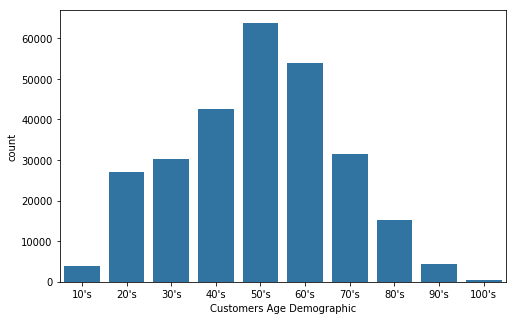

In [25]:
plot_customer_decade(df,'Customers Age Demographic')

### * For males,what is the most age demographic group?

In [26]:
#prepare the data to be plotted for decade and gender
cols = ["10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's",'gender_M']
df = df_all[cols]
df = df[df['gender_M']==1]
df = pd.melt(df[["10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's"]])
df = df[df['value']==1]
#validate
print(df_all[df_all['gender_M']==1]["10's"].sum())
print(df.variable.value_counts())

3042
50's     34689
60's     29034
40's     26078
30's     19563
20's     18290
70's     16489
80's      6748
10's      3042
90's      1713
100's       44
Name: variable, dtype: int64


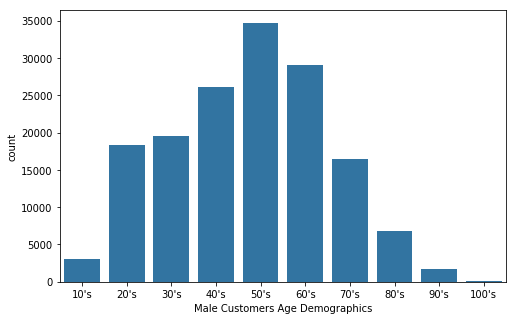

In [27]:
plot_customer_decade(df,'Male Customers Age Demographics')

### * for females,what is the most age demographic group?

In [28]:
#prepare the data to be plotted for decade and female
df = df_all[["10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's",'gender_F']]
df = df[df['gender_F']==1]
df = pd.melt(df[["10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's"]])
df = df[df['value']==1]
#validate
print(df_all[df_all['gender_F']==1]["10's"].sum())
print(df.variable.value_counts())

920
50's     28060
60's     24112
40's     15635
70's     14548
30's     10231
20's      8379
80's      8243
90's      2704
10's       920
100's      269
Name: variable, dtype: int64


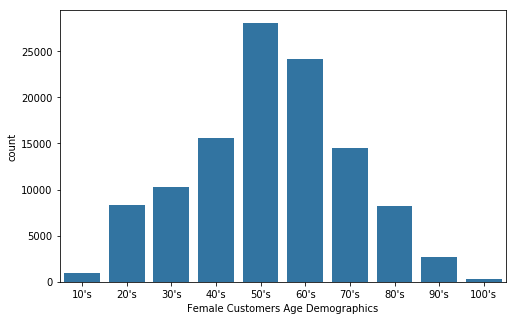

In [29]:
plot_customer_decade(df,'Female Customers Age Demographics')

### * What is the average customer spend in Starbucks transaction?

In [30]:
#check and validate the answer
df_all.transaction_amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: transaction_amount, dtype: float64

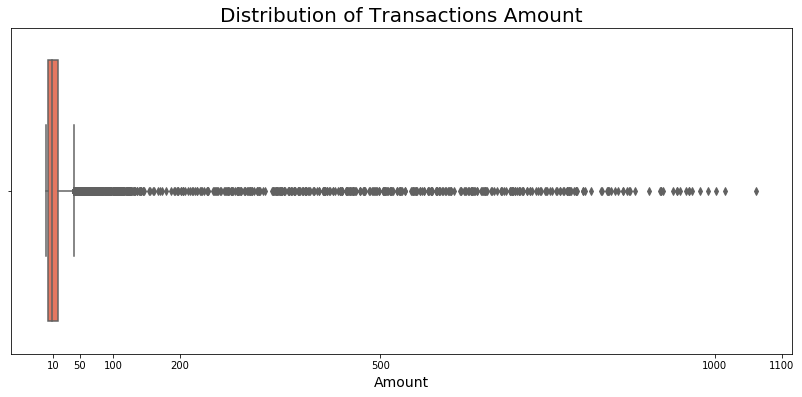

In [31]:
#plot it as boxplot
plt.figure(figsize=(14,6))
ax = sb.boxplot(x='transaction_amount', data=df_all, palette='Reds', orient='h')
plt.title("Distribution of Transactions Amount", fontsize=20, y=1)
plt.xlabel("Amount", fontsize=14, labelpad=5)
plt.xticks([10,50,100, 200, 500, 1000, 1100]);

### * who are the top 10 customers for starbucks mobile app by the amount spent? 

In [32]:
#validate and check the answer
df_all.groupby('person_id').transaction_amount.sum().nlargest(10).reset_index()

,person_id,transaction_amount
0,3c8d541112a74af99e88abbd0692f00e,1608.69
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
2,ae6f43089b674728a50b8727252d3305,1327.74
3,626df8678e2a4953b9098246418c9cfa,1321.42
4,73afdeca19e349b98f09e928644610f8,1319.97
5,52959f19113e4241a8cb3bef486c6412,1292.86
6,ad1f0a409ae642bc9a43f31f56c130fc,1258.19
7,d240308de0ee4cf8bb6072816268582b,1251.99
8,946fc0d3ecc4492aa4cc06cf6b1492c3,1232.40
9,6406abad8e2c4b8584e4f68003de148d,1211.76


In [33]:
#this famous function created in Seattle_AirBNB project in this Udacity term...

def plot(x,y,title,figsize=[20,10],plot="barplot",rotation=0):
    """"
    
    INPUTS:
    x: x-axis to be displayed
    y: y-axis to be displayed
    title: title for plot
    figsize: figure size to be passed -default [20,10]
    plot: if you want to use lineplot pointplot or the -default barplot
    rotation: if you want to rotate the x values text - default 0
    
    OUTPUT:
    
    Description:
    Plot display a chart visulatization either lineplot or pointplot
    """
    plt.figure(figsize = figsize);
    plt.title(title)
    clrs = ['grey' if (i <= np.mean(y)) else 'red' for i in y ]
    plt.xticks(rotation = rotation);
    if (plot == 'lineplot'):
        sns.lineplot(x, y, palette=clrs,sort=False);
    elif (plot =='pointplot') :
        sb.pointplot(y, x, palette=clrs);
    else:    
        sb.barplot(x, y, palette=clrs);
    return

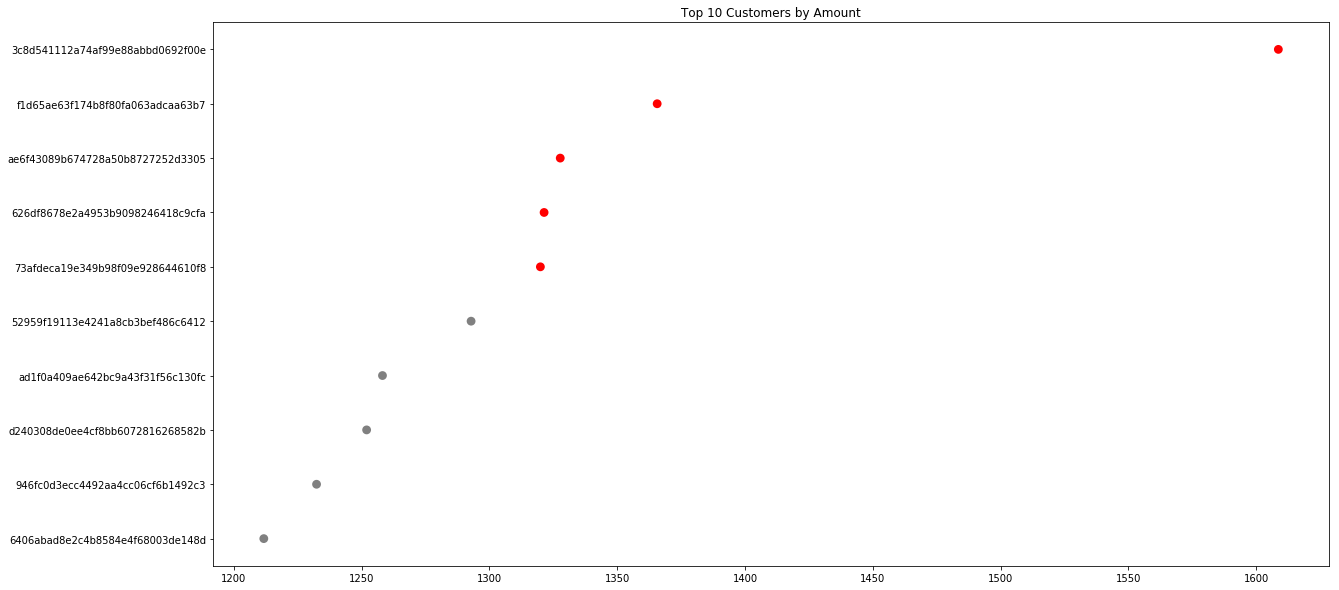

In [34]:
#prepare the data
x = np.array(df_all.groupby('person_id').transaction_amount.sum().nlargest(10).reset_index()['person_id'])
y = np.array(df_all.groupby('person_id').transaction_amount.sum().nlargest(10).reset_index()['transaction_amount'])
plot(x,y,'Top 10 Customers by Amount',plot='pointplot')

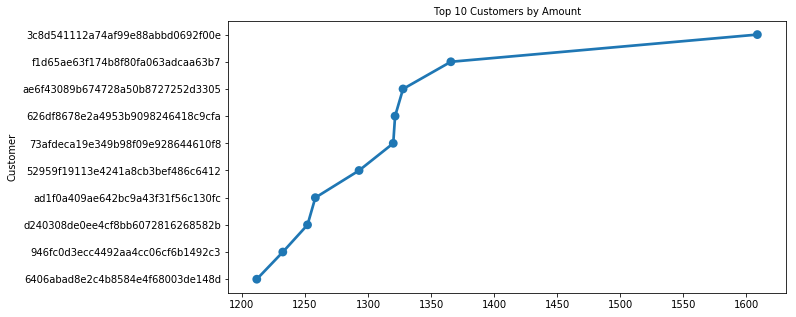

In [35]:
#plot it as pointplot
plt.figure(figsize = [10, 5]);
sb.pointplot(data = df_all.groupby('person_id').transaction_amount.sum().nlargest(10).reset_index(), x = 'transaction_amount', y = 'person_id')
plt.title("Top 10 Customers by Amount", fontsize=10, y=1)
plt.ylabel("Customer", fontsize=10, labelpad=5)
plt.xlabel("", fontsize=10, labelpad=5)
plt.show()

### * who are the top 10 customers for starbucks mobile app by the number of transactions?

In [36]:
#validate and check the answer
df_all.groupby('person_id').transaction.sum().nlargest(10).reset_index()

,person_id,transaction
0,79d9d4f86aca4bed9290350fb43817c2,36
1,8dbfa485249f409aa223a2130f40634a,36
2,94de646f7b6041228ca7dec82adb97d2,35
3,5e60c6aa3b834e44b822ea43a3efea26,32
4,b1f4ece7d49342628a9ed77aee2cde58,32
5,a42ed50acc4d4b25bca647c9e0b916ad,31
6,28681c16026943e68f26feaccab0907f,30
7,40ce078d5b2a43d19138a788754520be,30
8,4142f5e23db741b1af4be0287dc91c1c,30
9,ab25fd6fbd5040f880751921e4029757,30


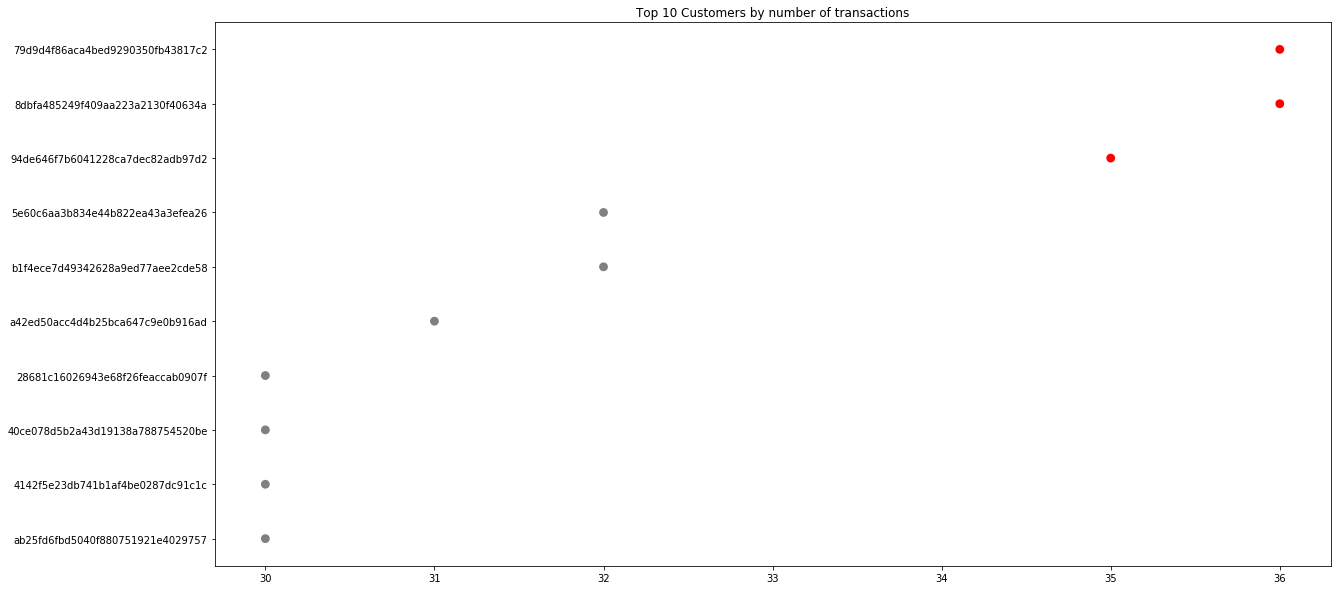

In [37]:
#prepare the data
x = np.array(df_all.groupby('person_id').transaction.sum().nlargest(10).reset_index()['person_id'])
y = np.array(df_all.groupby('person_id').transaction.sum().nlargest(10).reset_index()['transaction'])
plot(x,y,'Top 10 Customers by number of transactions',plot='pointplot')

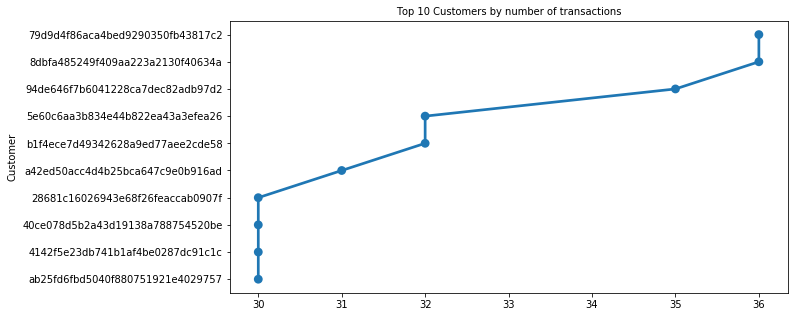

In [38]:
#plot it as pointplot
plt.figure(figsize = [10, 5]);
sb.pointplot(data = df_all.groupby('person_id').transaction.sum().nlargest(10).reset_index(), x = 'transaction', y = 'person_id')
plt.title("Top 10 Customers by number of transactions", fontsize=10, y=1)
plt.ylabel("Customer", fontsize=10, labelpad=5)
plt.xlabel("", fontsize=10, labelpad=5)
plt.show()

### * what is the most common (most completed) offer ?

In [39]:
#prepare the data
cols = ['offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5','offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10']
df = df_all[cols]
df = pd.melt(df[cols])
df = df[df['value']==1]
df.variable.value_counts()

offer_10    20241
offer_2     20139
offer_9     19131
offer_5     18222
offer_8     18062
offer_7     16202
offer_3     15767
offer_6     14305
offer_1     13751
offer_4     11761
Name: variable, dtype: int64

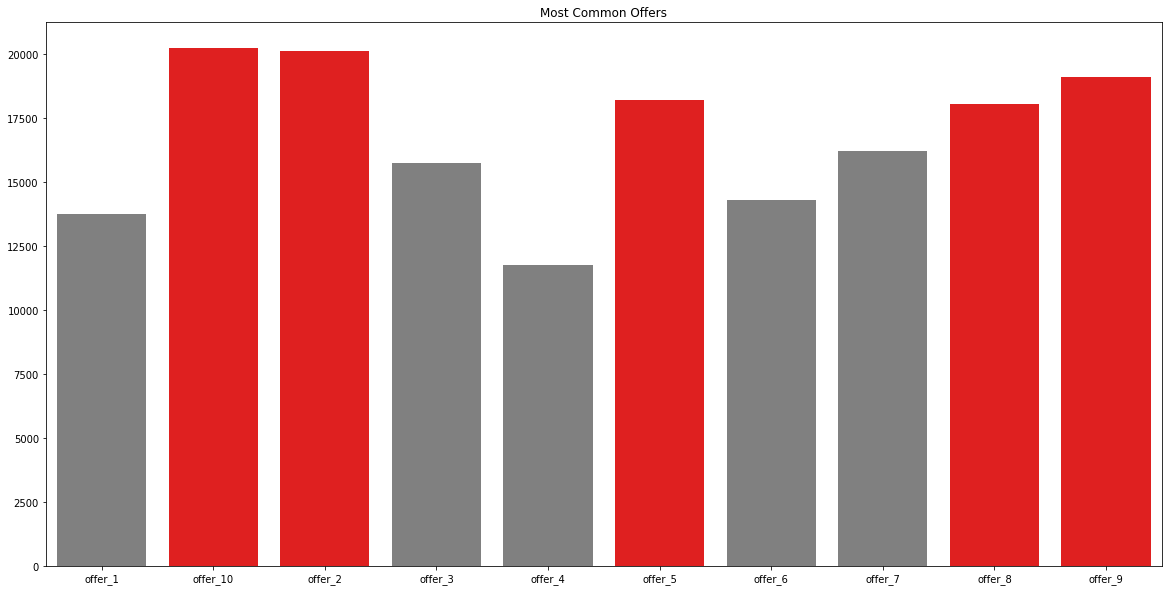

In [40]:
x = np.array(df.groupby('variable').count().reset_index()['variable'])
y = np.array(df.groupby('variable').count().reset_index()['value'])
plot(x,y,'Most Common Offers')

In [41]:
df = df_all[df_all['offer completed']==1]
df = df[cols]
df = pd.melt(df[cols])
df = df[df['value']==1]
df.variable.value_counts()

offer_10    5317
offer_2     5156
offer_7     4354
offer_9     4296
offer_3     4017
offer_8     3688
offer_1     3420
offer_5     3331
Name: variable, dtype: int64

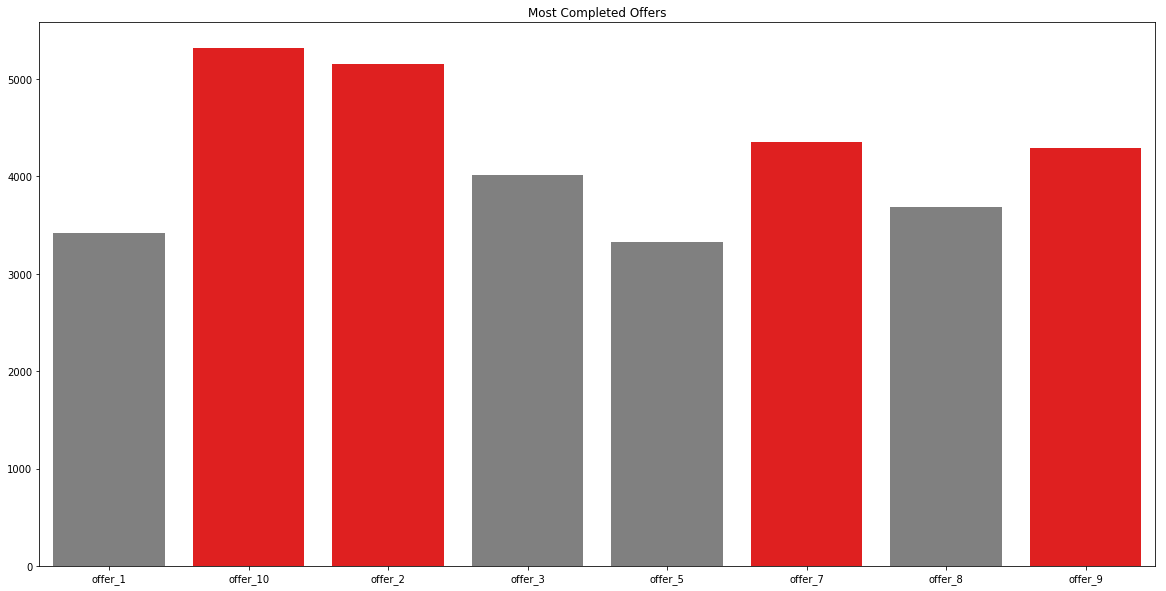

In [42]:
x = np.array(df.groupby('variable').count().reset_index()['variable'])
y = np.array(df.groupby('variable').count().reset_index()['value'])
plot(x,y,'Most Completed Offers')

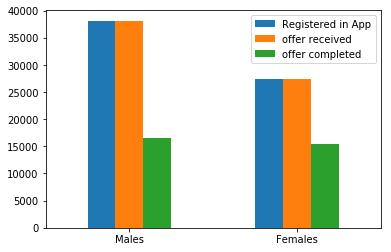

In [43]:
MaleA = df_all.gender_M.sum()
FemaleA = df_all.gender_F.sum()
MaleC = df_all[df_all['offer completed']== 1].gender_M.sum()
FemaleC = df_all[df_all['offer completed']== 1].gender_F.sum()
MaleR = df_all[df_all['offer received']== 1].gender_M.sum()
FemaleR = df_all[df_all['offer received']== 1].gender_F.sum()
available_app = [MaleA,FemaleA]
offer_received = [MaleR,FemaleR]
offer_completed = [MaleC,FemaleC]
index = ['Males','Females']
comp = pd.DataFrame({'Registered in App': offer_received,
                    'offer received': offer_received,
                   'offer completed': offer_completed}, index=index)
plt.figure(figsize=[16,5]);
ax = comp.plot.bar(rot=0);

## 4) Modeling

### here we are trying to create a model that predicts wither a customer will respond to an offer or not.

In [44]:
def model_data_prepare(df,result=1):
    '''
    INPUT:
    df - a dataframe contains most of starbucks mobile app customers data

    OUTPUT:
    df - a dataframe after dropping some columns and creating the result column
    Description:
    this function gets a dataframe delete the person_id and customer decade data and add a 'offer' result column
    '''
    dropped_cols = ['person_id',"10's", "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's","100's"]
#    df = df[df['offer received']==1]
#    if result == 1:
#        df['result'] = df['bogo'] + df['discount']
  
    for cols in dropped_cols :
        if cols in df.columns:
            df.drop(cols,axis=1,inplace=True)
    
   
        
    df.fillna(0,inplace=True)
#    df.dropna(0,inplace=True)
    
    return df

In [45]:
def get_train_test_split(df,result='bogo'):
    '''
    INPUT:
    df - a dataframe that was prepared by model_data_prepare
    
    OUTPUT:
    X_train  - a subset of the df contains the features fields to train the model 
    X_test   - a subset of the df contains the features fields to test the model
    y_train  - a subset of the df contains the field to be predicted to train the model 
    y_test   - a subset of the df contains the field to be predicted to test the model
    
    Description:
    this function gets a dataframe and split the data to train and test (y= result column)
    '''
    print(df.shape)
    df = df.drop_duplicates()
#    df = df[df['offer received']==1]
    print(df.shape)
    X = df.drop(result,axis=1)
    y = df[result]
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.025,random_state=42)
    print(X_train.shape)
    print(X_test.shape)
    print(X_train.columns)
        
    return X_train, X_test, y_train, y_test


In [46]:
df_all.columns

Index(['person_id', 'time', 'points', 'transaction_amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age', 'income',
       '10's', '20's', '30's', '40's', '50's', '60's', '70's', '80's', '90's',
       '100's', 'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration',
       'reward_y', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
       'offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10'],
      dtype='object')

In [47]:
Classifier = [  SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
                KNeighborsClassifier(n_neighbors=3),
                GaussianNB()]

X_train, X_test, y_train, y_test = get_train_test_split(model_data_prepare(df_all))
#X_train, X_test, y_train, y_test = get_train_test_split(model_data_prepare(df_all)
clf = []
score = 0
best_score = 0
for clf in Classifier:
    name = clf.__class__.__name__
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Result for ',name,':')
#    print('training score:',clf.score(X_train,y_train))
    score = clf.score(X_test,y_test)
    print('test score:',score)
    print(classification_report(y_test, y_pred,digits=4))
    if score > best_score:
        best_score = score
        model = clf
    


#    accuracy: (tp + tn) / (p + n)
#    accuracy = accuracy_score(y_test, y_pred)
#    print('Accuracy: %f' % accuracy)
#    precision tp / (tp + fp)
#    precision = precision_score(y_test, y_pred)
#    print('Precision: %f' % precision)
#    recall: tp / (tp + fn)
#    recall = recall_score(y_test, y_pred)
#    print('Recall: %f' % recall)
#    f1: 2 tp / (2 tp + fp + fn)
#    f1 = f1_score(y_test, y_pred)
#    print('F1 score: %f' % f1)

(306534, 32)
(282357, 32)
(275298, 31)
(7059, 31)
Index(['time', 'points', 'transaction_amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration',
       'reward_y', 'email', 'mobile', 'social', 'web', 'discount',
       'informational', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
       'offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10'],
      dtype='object')
Result for  SGDClassifier :
test score: 0.786938659867
             precision    recall  f1-score   support

        0.0     0.7870    0.9998    0.8807      5554
        1.0     0.6667    0.0013    0.0027      1505

avg / total     0.7613    0.7869    0.6935      7059

Result for  KNeighborsClassifier :
test score: 0.937951551211
             precision    recall  f1-score   support

        0.0     0.9581    0.9633    0.9607      5554
        1.0     0.8617    0.8445    0.8530      1505

avg / total     0

In [48]:
def create_model(df_all):
    '''
    INPUT:
    df_all - a dataframe that have most of starbucks mobile app customers data
    
    OUTPUT:
    clf    - randomforestregressor model optimized through hyperparameters
    
    Description:
    this function gets a full dataframe and split the data to train and test (y= result column)
    and make the model ready and optimized through the hyperparameters
    '''
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         KNeighborsClassifier(n_neighbors=3))
    hyperparameters = { 'n_neighbors' : [1,3,5,10],
                  'n_estimators=3': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    X_train, X_test, y_train, y_test = get_train_test_split(model_data_prepare(df_all))
    # Fit and tune model
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    y_pred = clf.predict(X_test)
    print(r2_score(y_test, y_pred))
    print(mean_squared_error(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return clf

In [49]:
df_all.columns

Index(['time', 'points', 'transaction_amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration',
       'reward_y', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
       'offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10'],
      dtype='object')

In [50]:
def train_model_score(clf,X_train,y_train,y_test,hyperparameters=dict()):
    
    clf = GridSearchCV(clf, hyperparameters,scoring='f1', verbose=30,cv=2,n_jobs=10)
    # Fit and tune model
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    y_pred = clf.predict(X_test)
    print('score:',clf.score(X_test,y_test))
    print(r2_score(y_test, y_pred))
    print(mean_squared_error(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return clf
    

In [51]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         KNeighborsClassifier())
hyperparameters = { 'kneighborsclassifier__n_neighbors' : [1,5],
#                    'kneighborsclassifier__weights': ['uniform','distance'],
                    'kneighborsclassifier__leaf_size': [1,10]
                  }
X_train, X_test, y_train, y_test = get_train_test_split(model_data_prepare(df_all))
print(pipeline.get_params().keys())
classifier = []
clf = train_model_score(pipeline,X_train,y_train,y_test,hyperparameters)
classifier.append(clf)

(306534, 32)
(282357, 32)
(275298, 31)
(7059, 31)
Index(['time', 'points', 'transaction_amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration',
       'reward_y', 'email', 'mobile', 'social', 'web', 'discount',
       'informational', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
       'offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10'],
      dtype='object')
dict_keys(['memory', 'steps', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] kneighborsclassifier__

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 55.6min


[CV]  kneighborsclassifier__leaf_size=10, kneighborsclassifier__n_neighbors=1, score=1.0, total=32.1min


[Parallel(n_jobs=10)]: Done   2 out of   8 | elapsed: 57.8min remaining: 173.3min


[CV]  kneighborsclassifier__leaf_size=10, kneighborsclassifier__n_neighbors=5, score=1.0, total=37.1min


[Parallel(n_jobs=10)]: Done   3 out of   8 | elapsed: 66.7min remaining: 111.1min


[CV]  kneighborsclassifier__leaf_size=10, kneighborsclassifier__n_neighbors=5, score=1.0, total=37.4min


[Parallel(n_jobs=10)]: Done   4 out of   8 | elapsed: 67.1min remaining: 67.1min


[CV]  kneighborsclassifier__leaf_size=1, kneighborsclassifier__n_neighbors=1, score=1.0, total=39.9min


[Parallel(n_jobs=10)]: Done   5 out of   8 | elapsed: 67.7min remaining: 40.6min


[CV]  kneighborsclassifier__leaf_size=1, kneighborsclassifier__n_neighbors=1, score=1.0, total=41.3min


[Parallel(n_jobs=10)]: Done   6 out of   8 | elapsed: 68.8min remaining: 22.9min


[CV]  kneighborsclassifier__leaf_size=1, kneighborsclassifier__n_neighbors=5, score=1.0, total=50.2min
[CV]  kneighborsclassifier__leaf_size=1, kneighborsclassifier__n_neighbors=5, score=1.0, total=51.1min


[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed: 74.3min remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed: 74.3min finished


{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 1}
score: 1.0
1.0
0.0
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      5554
        1.0       1.00      1.00      1.00      1505

avg / total       1.00      1.00      1.00      7059



In [52]:
#model = create_model(df_all)

In [53]:
def get_new_person(df_all,index=''):
    '''
    INPUT:
    df_all - a dataframe that have most of starbucks mobile app customers data
    index  - a specific customer index 
    OUTPUT:
    person    - random person that received an offer if no index was specified an exact person if the index was specified
    
    Description:
    this function gets a full dataframe and return a random person that received an offer if index was empty, and return
    the exact person if index was specified
    '''
    if index=='':
        person = model_data_prepare(df_all[df_all['offer received']==1].sample(1),0)
        print('person index is:',person.index.values)
    else:
        person = model_data_prepare(df_all[df_all.index==index],0)
        print('person index is:',person.index.values)
#    if (str(person.columns)).find('result')>=0:    
#        person = person.drop('result',axis=1)
    person = person.drop('bogo',axis=1)
    return person

In [54]:
def map_result(result):
    '''
    INPUT:
    result - the result of the model 0 or 1
    
    OUTPUT:
    
    Description:
    this function gets the result of the model prediction and print the corresponding text
    '''
    if result == 1:
        print('model predict the person will respond to an offer!')
    else:
        print('model predict the person will not respond to an offer!!')
    return

In [55]:
def predict_offer(df_all,index='',col=''):
    '''
    INPUT:
    df_all - a dataframe that have most of starbucks mobile app customers data
    index  - a specific customer index 
    
    OUTPUT:
    
    Description:
    this function gets a full dataframe and make model prediction for that person, if no index was specified
    it will pick a random customer through get_new_person make prediction and map the result through map_result
    '''
    if index=='':
        if col =='':
            map_result(model.predict(get_new_person(df_all)).drop(col,axis=1))
        else:    
            map_result(model.predict(get_new_person(df_all)))
    else:
        if col =='':
            map_result(model.predict(get_new_person(df_all)).drop(col,axis=1))
        else:
            map_result(model.predict(get_new_person(df_all,index)))
        
    return
    

In [56]:
model = classifier[0]

In [57]:
#test predict_offer function 
for i in range(10):
    predict_offer(df_all,col='bogo')

predict_offer(df_all,index=116804,col='bogo')

person index is: [210517]
model predict the person will not respond to an offer!!
person index is: [12280]
model predict the person will not respond to an offer!!
person index is: [210930]
model predict the person will respond to an offer!
person index is: [121192]
model predict the person will not respond to an offer!!
person index is: [6903]
model predict the person will respond to an offer!
person index is: [256938]
model predict the person will not respond to an offer!!
person index is: [159149]
model predict the person will not respond to an offer!!
person index is: [255969]
model predict the person will not respond to an offer!!
person index is: [254064]
model predict the person will not respond to an offer!!
person index is: [122830]
model predict the person will not respond to an offer!!
person index is: [116804]
model predict the person will not respond to an offer!!


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
